In [1]:
library(ggplot2)
library(reshape2)
library(dplyr)
library(stringr)
library(tidyr)
theme_set(theme_bw())
options(repr.plot.width=7, repr.plot.height=4)
isotypes = c('Ala', 'Arg', 'Asn', 'Asp', 'Cys', 'Gln', 'Glu', 'Gly', 'His', 'Ile', 'iMet', 'Leu', 'Lys', 'Met', 'Phe', 'Pro', 'Ser', 'Thr', 'Trp', 'Tyr', 'Val')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:reshape2’:

    smiths



# Introduction

In [clade-freqs](clade-freqs.ipynb), I've annotated a list of identity elements that appear to be conserved in over 95% of tRNAs. Some of these are reflected in the literature; others are not. I expect that the well-studied IDEs that are agreed to be universal to hold true. Thus, I need to look into the tRNAs that *don't* have this IDE. 

Do these exceptions function as tRNAs? Using a suite of supposedly gold standard IDEs, we would expect to be able to differentiate between bona fide tRNAs and tRNA pseudogenes.

I'll get a set of tRNAs that may or may not be missing a key IDE. I'll then proceed in two branches. 
1) IDE rules. We've learned something about which IDEs are required. We now know how to choose canonical tRNAs. Filter based on these IDEs or based on suites of IDEs, regenerate frequencies, rinse and repeat.
2) Interesting exceptions to the rule. Some tRNAs are exceptional. Look deeply into a few examples where they're missing a key IDE. Are any of them functional? Are they missing all of the other IDEs?
 
#2 is easier to tackle first, as we isolate the tRNAs. First, we'll recreate the frequency table.

# Data wrangling

## Import alignment and bases


In [2]:
identities = read.delim('identities.tsv', sep='\t', stringsAsFactors=FALSE)
identities$quality = as.logical(identities$quality)
identities$restrict = as.logical(identities$restrict)

In [3]:
positions = colnames(identities)[which(str_detect(colnames(identities), "X\\d+\\.\\d+$"))]
positions = c(positions, 'X8', 'X9', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X20a', 'X21', 'X26', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X44', 'X45', 'X46', 'X47', 'X48', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X73')

## Get frequencies

In [114]:
clade_iso_ac_freqs = identities %>%
  filter(quality & (!restrict | isotype == "iMet")) %>%
  select(match(c('clade', 'isotype', 'anticodon', positions), colnames(identities))) %>%
  gather(positions, bases, -clade, -isotype, -anticodon) %>%
  group_by(clade, isotype, anticodon, positions, bases) %>%
  tally() %>%
  group_by(clade, isotype, anticodon, positions) %>%
  mutate(freq=n) %>%
  group_by(clade, isotype, anticodon, positions) %>%
  summarize(A = sum(freq[bases == "A"]),
            C = sum(freq[bases == "C"]),
            G = sum(freq[bases == "G"]),
            U = sum(freq[bases == "U"]),
            Deletion = sum(freq[bases %in% c("-", ".")]), 
            Purine = sum(freq[bases %in% c("A", "G")]),
            Pyrimidine = sum(freq[bases %in% c("C", "U")]),
            Weak = sum(freq[bases %in% c("A", "U")]),
            Strong = sum(freq[bases %in% c("G", "C")]),
            Amino = sum(freq[bases %in% c("A", "C")]),
            Keto = sum(freq[bases %in% c("G", "U")]),
            B = sum(freq[bases %in% c("C", "G", "U")]),
            D = sum(freq[bases %in% c("A", "G", "U")]),
            H = sum(freq[bases %in% c("A", "C", "U")]),
            V = sum(freq[bases %in% c("A", "C", "G")]),
            D = sum(freq[bases %in% c("A", "G", "U")]),
            GC = sum(freq[bases == "G:C"]),
            AU = sum(freq[bases == "A:U"]),
            UA = sum(freq[bases == "U:A"]),
            CG = sum(freq[bases == "C:G"]),
            GU = sum(freq[bases == "G:U"]),
            UG = sum(freq[bases == "U:G"]),
            PairDeletion = sum(freq[bases == "-:-"]), 
            PurinePyrimidine = sum(freq[bases %in% c("A:U", "G:C")]),
            PyrimidinePurine = sum(freq[bases %in% c("U:A", "C:G")]),
            StrongPair = sum(freq[bases %in% c("G:C", "C:G")]),
            WeakPair = sum(freq[bases %in% c("A:U", "U:A")]),
            Wobble = sum(freq[bases %in% c("G:U", "U:G")]),
            Paired = sum(freq[bases %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G")]),
            Bulge = sum(freq[bases %in% c("A:-", "U:-", "C:-", "G:-", "-:A", "-:G", "-:C", "-:U")]),
            Mismatched = sum(freq[bases %in% c("A:A", "G:G", "C:C", "U:U", "A:G", "A:C", "C:A", "C:U", "G:A", "U:C")])
            ) %>%
  mutate(total = A + B + Deletion + Paired + Mismatched + Bulge + PairDeletion) %>%
  melt(id.vars=c("clade", "isotype", "anticodon", "positions", "total")) %>%
  mutate(freq=value/total)

In [115]:
clade_iso_freqs = clade_iso_ac_freqs %>%
  group_by(positions, isotype, variable) %>%
  summarize(count=sum(value), freq=sum(value)/sum(total))

euk_freqs = clade_iso_ac_freqs %>%
  group_by(positions, variable) %>%
  summarize(count=sum(value), freq=sum(value)/sum(total))

consensus = euk_freqs %>%
  filter(freq > 0.95) %>%
  group_by(positions) %>% # remove duplicates
  filter(row_number(freq) == 1) %>%
  filter(!(positions %in% c("X8", "X14", "X15", "X48", "X18", "X19", "X55", "X56"))) %>%
  arrange(positions)
consensus

,positions,variable,count,freq
1,X10.25,Paired,46359,0.9972465
2,X15.48,Paired,44501,0.957299
3,X16,B,45087,0.9698841
4,X1.72,Paired,46207,0.9944046
5,X18.55,GU,46063,0.9908792
6,X19.56,GC,45915,0.9876955
7,X20,H,44899,0.9658399
8,X21,A,46351,0.9970745
9,X26,D,44787,0.9634306
10,X2.71,Paired,44417,0.955677


# Analysis of eukaryotic all-tRNA consensus identity elements

## 2:71

This one is not mentioned in M&G often, but they do note a dependency for alanine. Giegé lists C2:G71 for glycine.

It seems like 2:71 is typically a strong pair, perhaps to strengthen the acceptor stem.

In [116]:
clade_iso_ac_freqs %>% filter(positions == 'X2.71') %>%
  group_by(positions, isotype, variable) %>%
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
  filter(freq > 0.9) %>% filter(row_number(freq) == 1 & variable != "Paired")

,positions,isotype,variable,count,freq
1,X2.71,Ala,GC,3260,0.9848943
2,X2.71,Cys,GC,1770,0.9325606
3,X2.71,Gln,Mismatched,1846,0.9951482
4,X2.71,Glu,CG,2499,0.9857988
5,X2.71,Gly,CG,3017,0.9556541
6,X2.71,His,PyrimidinePurine,1105,0.9642234
7,X2.71,Ile,StrongPair,2139,0.9807428
8,X2.71,Lys,CG,3046,0.9787918
9,X2.71,Met,StrongPair,1059,0.9396628
10,X2.71,Phe,CG,1342,0.9457364



## 3:70

M&G: Even numbers across all pairs, 9 mismatches. G3-U70 unique to Ala. A few other isotypes have single exceptions. Antideterminant for Thr. C3-G70 positive for iMet. Dependent on 2-71 context.

First, let's check the iMet frequencies. 

In [117]:
clade_iso_ac_freqs %>% filter(positions == 'X3.70' & isotype == "iMet") %>%
  group_by(positions, isotype, variable) %>%
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
  filter(freq > 0.05)

,positions,isotype,variable,count,freq
1,X3.70,iMet,CG,1171,0.9991468
2,X3.70,iMet,PyrimidinePurine,1171,0.9991468
3,X3.70,iMet,StrongPair,1171,0.9991468
4,X3.70,iMet,Paired,1172,1


M&G's frequencies with iMet are confirmed. This is a pretty strong determinant for initiator methionine.

For alanine, previous work (e.g. with [Chihade et al. 1998](http://pubs.acs.org/doi/pdf/10.1021/bi9804636)) shows that G3-U70 is a strong determinant in *C. elegans*. M&G do find that a few other tRNAs also contain G3-U70. [Beuning et al. 2002](http://rnajournal.cshlp.org/content/8/5/659.full.pdf) also shows that the orientation of a 2:71 purine:pyrimidine pair is helpful for charging. Let's see if G3-U70 is specifically enriched in alanine.

In [118]:
clade_iso_ac_freqs %>% filter(positions == 'X3.70' & variable == "GU") %>%
  group_by(positions, isotype, variable) %>%
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
  filter(freq > 0.001)

,positions,isotype,variable,count,freq
1,X3.70,Ala,GU,3199,0.9664653
2,X3.70,Cys,GU,11,0.005795574
3,X3.70,Gly,GU,15,0.004751346


This basically confirms M&G's (non-)conclusions - GU is enriched for Ala, though no recriprocal relationship exists, except for Ala-NGC.

## U8-A14

This is known to be extremely conserved, since it stabilizes the tertiary structure. M&G found that a variety of bacteria and archaea contain a C8 variation. Our data fits the eukaryotic side of things at 97%.

## R9 and 9:23

M&G: mostly a purine here. Interacts with base 23 in class I tRNAs. 

Our data supports this, and goes a step further in class II tRNAs, where it's a G9. The 9-23 interaction is not restricted to a particular interaction in any way, which agrees with my previous [tertiary interactions analysis](../tertiary-interactions.ipynb), where I proposed that it is an isotype- and clade-specific IDE. As for fungi, it would appear that the 9:23 interaction exhibits more pairing behavior, but is still typically mismatched as in other clades. Then again, it's not even listed as part of the consensus IDEs found above.

In [119]:
clade_iso_ac_freqs %>% filter(!(isotype %in% c("Ser", "Leu")) & positions %in% c('X9', 'X9.23')) %>%
  group_by(positions, variable) %>%
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
  filter(freq > 0.9) %>% filter(row_number(freq) == 1)

clade_iso_ac_freqs %>% filter(isotype %in% c("Ser", "Leu") & positions %in% c('X9', 'X9.23')) %>%
  group_by(positions, variable) %>%
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
  filter(freq > 0.9) %>% filter(row_number(freq) == 1)

clade_iso_ac_freqs %>% filter(positions == 'X9.23') %>%
  group_by(positions, clade, variable) %>%
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
  filter(freq > 0.1)

,positions,variable,count,freq
1,X9,Purine,39055,0.9764482
2,X9.23,Mismatched,36234,0.9059179


,positions,variable,count,freq
1,X9,G,6466,0.996302
2,X9.23,Mismatched,6204,0.9559322


,positions,clade,variable,count,freq
1,X9.23,Fungi,GU,1099,0.1014774
2,X9.23,Fungi,Wobble,1099,0.1014774
3,X9.23,Fungi,Paired,1578,0.1457064
4,X9.23,Fungi,Mismatched,9252,0.8542936
5,X9.23,Insecta,Mismatched,900,0.9018036
6,X9.23,Mammalia,Mismatched,13300,0.9410599
7,X9.23,Nematoda,Mismatched,3639,0.9321209
8,X9.23,Spermatophyta,Paired,207,0.1212654
9,X9.23,Spermatophyta,Mismatched,1500,0.8787346
10,X9.23,Streptophyta,Paired,508,0.104141


## 10:25

M&G: 10/41 GC, 31/41 GU, positive determinant for yeast Asp, negative determinant for yeast M22G on 26, interacts with 45.

This is pretty par for the course. Our data show that GC $\approx$ 75% is more common though (GU $\approx$ 22%).

In [120]:
euk_freqs %>% filter(positions == 'X10.25' & freq > 0.1)

,positions,variable,count,freq
1,X10.25,GC,34254,0.7368512
2,X10.25,GU,11262,0.2422613
3,X10.25,PurinePyrimidine,34372,0.7393895
4,X10.25,StrongPair,34554,0.7433046
5,X10.25,Wobble,11264,0.2423043
6,X10.25,Paired,46359,0.9972465


## A14

This is an invariant position, mentioned in M&G, involved in U8:A14.

## R15, 15:48

This is the Levitt base pair. M&G note that this usually forms R15:Y48, but has been shown in *E. coli* to tolerate different combinations. Our data show support for a R15:Y48 requirement.

In [121]:
clade_iso_ac_freqs %>% filter(positions == "X15.48") %>%
  group_by(positions, variable) %>%
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
  filter(freq > 0.1)

,positions,variable,count,freq
1,X15.48,GC,36600,0.7873338
2,X15.48,AU,7482,0.1609517
3,X15.48,PurinePyrimidine,44082,0.9482855
4,X15.48,StrongPair,36600,0.7873338
5,X15.48,WeakPair,7482,0.1609517
6,X15.48,Paired,44501,0.957299


## B16

In M&G, 16 is most commonly a U. There's lower conservation here. This position is commonly modified to a D, so a U makes sense. But it's also strange that a position thought to be important for synthetase recognition doesn't exhibit strong conservation. The same goes for position 17.

In [122]:
clade_iso_ac_freqs %>% filter(positions %in% c('X16')) %>%
  group_by(positions, variable) %>%
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
  filter(variable %in% c("A", "C", "G", "U"))

,positions,variable,count,freq
1,X16,A,1397,0.03005141
2,X16,C,6193,0.13322
3,X16,G,2674,0.05752146
4,X16,U,36220,0.7791426


## G18:U55, 19:56

M&G: G18:U55, G19 in eukaryotes. G19:U56 is common enough. Data shows invariant G19:C56 in eukaryotes. 4 bases downstream from 14 is always a G - so what they were trying to say was a conserved G18. 

They locked in the search strategy to require G18 and R19, and our data doesn't show otherwise.

In [123]:
clade_iso_ac_freqs %>% filter(positions %in% c("X18.55", "X19.56")) %>%
  group_by(positions, variable) %>% 
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
  filter(freq > 0.1) %>%
  group_by(positions) %>% # remove duplicates
  filter(row_number(freq) == 1)

,positions,variable,count,freq
1,X18.55,GU,46063,0.9908792
2,X19.56,GC,45915,0.9876955


## H20

M&G: Mostly U. G20 is exclusive to Phe-GAA, and vice versa, barring 1 exception.

This base is almost certainly involved in 3d structure, whether as a spacer or stacking nucleotide. Our data shows many tRNAs that don't have a U. G20 does seem to be conserved in Phe-GAA too. It also looks like A20 in arginine is fairly well conserved with respect to the other isotypes.

In [124]:
clade_iso_ac_freqs %>% filter(positions %in% c("X20")) %>% group_by(positions, variable) %>% summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
  filter(variable %in% c("A", "G", "C", "U"))

clade_iso_ac_freqs %>% filter(positions %in% c("X20")) %>% group_by(positions, isotype, anticodon, variable) %>% summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
  filter(variable %in% c("A", "G", "C") & freq > 0.5 & count > 10)

clade_iso_ac_freqs %>% filter(positions %in% c("X20") & isotype == "Arg") %>% group_by(positions, isotype, variable) %>% summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
  filter(variable %in% c("A", "G", "C", "U"))

,positions,variable,count,freq
1,X20,A,4035,0.08679846
2,X20,C,3063,0.06588939
3,X20,G,1588,0.03416009
4,X20,U,37801,0.8131521


,positions,isotype,anticodon,variable,count,freq
1,X20,Arg,ACG,A,693,0.6985887
2,X20,Arg,CCG,A,258,0.8628763
3,X20,Arg,CCT,A,436,0.8466019
4,X20,Arg,TCG,A,484,0.75625
5,X20,Arg,TCT,A,578,0.6963855
6,X20,iMet,CAT,A,1102,0.940273
7,X20,Met,CAT,C,753,0.6681455
8,X20,Phe,GAA,G,1391,0.9802678


,positions,isotype,variable,count,freq
1,X20,Arg,A,2449,0.747558
2,X20,Arg,C,389,0.1187424
3,X20,Arg,G,1,0.0003052503
4,X20,Arg,U,437,0.1333944


## A21

M&G: A21 is invariant except for G21 in Met-CAT in *S. pombe*.

This base stacks with 8:14. However, I don't see G21 at all. 

In [125]:
clade_iso_ac_freqs %>% filter(positions == "X21") %>% group_by(positions, variable) %>% summarize(count=sum(value), freq=sum(value)/sum(total)) %>% filter(freq > 0.5) %>% filter(row_number(freq) == 1)

clade_iso_ac_freqs %>% filter(positions == "X21") %>% group_by(positions, clade, isotype, anticodon, variable)%>% summarize(count=sum(value), freq=sum(value)/sum(total)) %>% filter(clade == "Fungi" & isotype == "Met" & variable %in% c("U", "G", "C", "A"))

,positions,variable,count,freq
1,X21,A,46351,0.9970745


,positions,clade,isotype,anticodon,variable,count,freq
1,X21,Fungi,Met,CAT,A,209,1
2,X21,Fungi,Met,CAT,C,0,0
3,X21,Fungi,Met,CAT,G,0,0
4,X21,Fungi,Met,CAT,U,0,0


Digging in more deeply, the *S. pombe* tRNAs score poorly, and align better to the threonine CM. Previously, the alignment has U20-G20a-G21. However, the alignment places a gap at 21 and 22, and places the insertion before 20a.

This is an exceedingly rare exception - almost all other tRNAs have this aligned properly, as shown in [euk-tRNAs](../euk-tRNAs.ipynb). 

In [126]:
identities[identities$clade == "Fungi" & identities$isotype_ac == "Met" & identities$species == "schiPomb_972H", ]

,clade,domain,isotype,seqname,species,species_long,isotype_ac,anticodon,score,isoscore,GC,D.loop,AC.loop,TPC.loop,V.arm,intron,insertions,deletions,quality,restrict,X0i1,X0i2,X0i3,X0i4,X0i5,X0i6,X0i7,X0i8,X0i9,X0i10,X0i11,X1.72,X1,X1i1,X2.71,X2,X2i1,X3.70,X3,X3i1,X3i2,X3i3,X3i4,X3i5,X3i6,X3i7,X4.69,X4,X4i1,X4i2,X4i3,X4i4,X4i5,X4i6,X4i7,X4i8,X4i9,X4i10,X4i11,X5.68,X5,X5i1,X5i2,X5i3,X5i4,X5i5,X5i6,X5i7,X6.67,X6,X6i1,X7.66,X7,X7i1,X7i2,X7i3,X7i4,X7i5,X7i6,X7i7,X7i8,X7i9,X7i10,X7i11,X7i12,X7i13,X7i14,X8,X8.14.21,X8.14,X8i1,X8i2,X8i3,X8i4,X9,X9.12.23,X9.23,X9i1,X9i2,X9i3,X10.25,X10,X10.25.45,X10.45,X10i1,X11.24,X11,X12.23,X12,X12i1,X12i2,X12i3,X12i4,X13.22,X13,X13.22.46,X13i1,X14,X14i1,X14i2,X14i3,X14i4,X14i5,X14i6,X14i7,X14i8,X14i9,X14i10,X14i11,X14i12,X14i13,X14i14,X14i15,X14i16,X14i17,X14i18,X14i19,X14i20,X14i21,X14i22,X14i23,X14i24,X14i25,X15,X15.48,X16,X16i1,X16i2,X16i3,X16i4,X16i5,X16i6,X16i7,X16i8,X16i9,X16i10,X16i11,X16i12,X16i13,X16i14,X16i15,X16i16,X16i17,X16i18,X16i19,X16i20,X17,X17i1,X17i2,X17i3,X18,X18.55,X19,X19.56,X20,X20i1,X20i2,X20i3,X20i4,X20i5,X20i6,X20i7,X20i8,X20i9,X20i10,X20a,X20b,X21,X21i1,X22,X22.46,X22i1,X23,X23i1,X24,X24i1,X25,X25i1,X25i2,X25i3,X25i4,X25i5,X25i6,X25i7,X25i8,X25i9,X25i10,X25i11,X25i12,X25i13,X26,X26.44,X26i1,X26i2,X26i3,X26i4,X27.43,X27,X27i1,X27i2,X27i3,X27i4,X27i5,X28.42,X28,X28i1,X28i2,X28i3,X28i4,X29.41,X29,X29i1,X30.40,X30,X30i1,X31.39,X31,X32,X33,X34,X35,X35i1,X36,X37,X37i1,X37i2,X37i3,X37i4,X37i5,X37i6,X37i7,X37i8,X37i9,X37i10,X37i11,X37i12,X37i13,X37i14,X37i15,X37i16,X37i17,X37i18,X37i19,X37i20,X37i21,X37i22,X37i23,X37i24,X37i25,X37i26,X37i27,X37i28,X37i29,X37i30,X37i31,X37i32,X37i33,X37i34,X37i35,X37i36,X37i37,X37i38,X37i39,X37i40,X37i41,X37i42,X37i43,X37i44,X37i45,X37i46,X37i47,X37i48,X37i49,X37i50,X37i51,X37i52,X37i53,X37i54,X37i55,X37i56,X37i57,X37i58,X37i59,X37i60,X37i61,X37i62,X37i63,X37i64,X37i65,X37i66,X37i67,X37i68,X37i69,X37i70,X37i71,X37i72,X37i73,X37i74,X37i75,X37i76,X37i77,X37i78,X37i79,X37i80,X37i81,X37i82,X37i83,X37i84,X37i85,X37i86,X37i87,X37i88,X37i89,X37i90,X37i91,X37i92,X37i93,X37i94,X37i95,X37i96,X37i97,X37i98,X37i99,X37i100,X37i101,X37i102,X37i103,X37i104,X37i105,X37i106,X37i107,X37i108,X37i109,X37i110,X37i111,X37i112,X37i113,X37i114,X37i115,X37i116,X37i117,X37i118,X37i119,X37i120,X37i121,X37i122,X37i123,X37i124,X37i125,X37i126,X37i127,X37i128,X37i129,X37i130,X37i131,X37i132,X37i133,X37i134,X37i135,X37i136,X37i137,X37i138,X37i139,X37i140,X37i141,X37i142,X37i143,X37i144,X37i145,X37i146,X37i147,X37i148,X37i149,X37i150,X37i151,X37i152,X37i153,X37i154,X37i155,X37i156,X37i157,X37i158,X37i159,X37i160,X37i161,X37i162,X37i163,X37i164,X37i165,X37i166,X37i167,X37i168,X37i169,X37i170,X37i171,X37i172,X37i173,X37i174,X37i175,X37i176,X37i177,X37i178,X37i179,X37i180,X37i181,X37i182,X37i183,X37i184,X37i185,X37i186,X37i187,X37i188,X37i189,X37i190,X37i191,X37i192,X37i193,X37i194,X37i195,X37i196,X37i197,X37i198,X37i199,X37i200,X37i201,X37i202,X37i203,X37i204,X37i205,X37i206,X37i207,X37i208,X37i209,X37i210,X37i211,X37i212,X37i213,X37i214,X37i215,X37i216,X37i217,X37i218,X37i219,X37i220,X37i221,X37i222,X37i223,X37i224,X37i225,X37i226,X37i227,X37i228,X37i229,X37i230,X37i231,X37i232,X37i233,X37i234,X37i235,X37i236,X37i237,X37i238,X37i239,X37i240,X37i241,X37i242,X37i243,X37i244,X37i245,X37i246,X37i247,X37i248,X37i249,X37i250,X37i251,X37i252,X37i253,X37i254,X37i255,X37i256,X37i257,X37i258,X37i259,X37i260,X37i261,X37i262,X37i263,X37i264,X37i265,X37i266,X37i267,X37i268,X37i269,X37i270,X37i271,X37i272,X37i273,X37i274,X37i275,X37i276,X37i277,X37i278,X37i279,X37i280,X37i281,X37i282,X37i283,X37i284,X37i285,X37i286,X37i287,X37i288,X37i289,X37i290,X37i291,X37i292,X37i293,X37i294,X37i295,X37i296,X37i297,X37i298,X37i299,X37i300,X37i301,X37i302,X37i303,X37i304,X37i305,X37i306,X37i307,X37i308,X37i309,X37i310,X37i311,X37i312,X37i313,X37i314,X37i315,X37i316,X37i317,X37i318,X37i319,X37i320,X37i321,X37i322,X37i323,X37i324,X37i325,X37i326,X37i327,X37i328,X37i329,X37i330,X37i331,X37i332,X37i333,X37i334,X3

## D26, D44, 26:44

M&G don't say much about this. Our data show a near-universal consensus for anything but C at these positions. In [tertiary-interactions](../tertiary-interactions.ipynb) I show that this is most commonly G26:A44 (about half of tRNAs), but it's not a strong identity element.

## 27:43

## Y32, H38

M&G: WC pairs rare at 32:38, but there tends to be a weak pairing here for a more stable AC stem-loop. Auffinger and Westhof (1999) showcase a variety of weak pairings (e.g., single hydrogen bond).

Giegé lists C38 as a determinant for Asp across the domains. This is confirmed, but clearly a ton of other tRNAs also have a conserved position 38.

In [127]:
clade_iso_ac_freqs %>% filter(positions %in% c("X32", "X38")) %>% 
  group_by(positions, variable) %>% 
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
  filter(freq > 0.95 | variable %in% c("A", "C", "G", "U"))

clade_iso_ac_freqs %>% filter(positions == "X38") %>% 
  group_by(positions, isotype, variable) %>% 
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>% 
  filter(freq > 0.95 & variable %in% c("A", "C", "G", "U"))

,positions,variable,count,freq
1,X32,A,32,0.0006883645
2,X32,C,32947,0.7087358
3,X32,G,55,0.001183126
4,X32,U,13453,0.2893927
5,X32,Pyrimidine,46400,0.9981285
6,X32,B,46455,0.9993116
7,X32,H,46432,0.9988169
8,X38,A,26934,0.5793878
9,X38,C,10835,0.2330759
10,X38,G,42,0.0009034784


,positions,isotype,variable,count,freq
1,X38,Asn,A,1744,0.9971412
2,X38,Asp,C,1911,0.9958312
3,X38,Cys,A,1868,0.9841939
4,X38,Glu,C,2508,0.9893491
5,X38,His,C,1107,0.9659686
6,X38,Ile,A,2174,0.9967905
7,X38,iMet,A,1172,1
8,X38,Lys,A,3105,0.9967897
9,X38,Met,A,1123,0.9964508
10,X38,Phe,A,1378,0.9711064


## U33

M&G: Strong U33 IDE. Exceptions exist. This is reflected clearly in our data.

## R37

34, 35, and 36 are the anticodon, and 37 is known as the base before the intron. Thus, it should be conserved as it is needed for splice site recognition. M&G note that it is almost always a purine. Giegé et al. list Leu-G37 and Phe-A37 as determinants. While Giegé et al. are correct about Leu-G37, Phenylalanine typically contains G37 too. Like with position 38, many other isotypes have their own preferences, with 15 above 95% frequency.

Overall, our data show that 70% of the time, it's an A, only slightly higher than in M&G, where the ratio was closer to 2:1. 

In [128]:
clade_iso_ac_freqs %>% filter(positions == "X37") %>% 
  group_by(positions, variable) %>% 
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>% 
  filter(variable %in% c("A", "C", "G", "U"))

clade_iso_ac_freqs %>% filter(positions == "X37") %>% 
  group_by(positions, isotype, variable) %>% 
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>% 
  filter(variable %in% c("A", "C", "G", "U") & freq > 0.9)

,positions,variable,count,freq
1,X37,A,32353,0.695958
2,X37,C,27,0.0005808075
3,X37,G,14085,0.3029879
4,X37,U,22,0.0004732506


,positions,isotype,variable,count,freq
1,X37,Ala,A,3303,0.9978852
2,X37,Asn,A,1746,0.9982847
3,X37,Cys,G,1739,0.9162276
4,X37,Gln,A,1854,0.9994609
5,X37,Glu,A,2524,0.9956607
6,X37,Gly,A,3154,0.9990497
7,X37,His,G,1145,0.9991274
8,X37,Ile,A,2105,0.9651536
9,X37,iMet,A,1172,1
10,X37,Leu,G,3216,0.9950495


## R46, Y48

These two are relatively unknown and not talked about. Could be new identity elements. What could 46/48 be used for? A long variable loop exists in Type II tRNAs and is surmised to happen at position 47. 

In [129]:
clade_iso_ac_freqs %>% filter(positions %in% c("X46", "X48")) %>%
  group_by(positions, clade, variable) %>% 
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>% 
  filter(freq > 0.2)

,positions,clade,variable,count,freq
1,X46,Fungi,A,2425,0.2239151
2,X46,Fungi,G,8274,0.7639889
3,X46,Fungi,Purine,10699,0.987904
4,X46,Fungi,Weak,2547,0.2351801
5,X46,Fungi,Strong,8281,0.7646353
6,X46,Fungi,Amino,2432,0.2245614
7,X46,Fungi,Keto,8396,0.7752539
8,X46,Fungi,B,8403,0.7759003
9,X46,Fungi,D,10821,0.999169
10,X46,Fungi,H,2554,0.2358264


In [130]:
clade_iso_ac_freqs %>% filter(positions %in% c("X46", "X48")) %>%
  group_by(positions, variable) %>% 
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>% 
  filter(variable %in% c("A", "C", "G", "U"))

,positions,variable,count,freq
1,X46,A,6464,0.1390496
2,X46,C,47,0.001011035
3,X46,G,39711,0.8542388
4,X46,U,241,0.005184245
5,X48,A,995,0.02140429
6,X48,C,37456,0.805748
7,X48,G,133,0.002861076
8,X48,U,7899,0.1699221


There's a difference between Type I and Type II tRNAs here. Something fishy is going on...

In [131]:
clade_iso_ac_freqs %>% filter(positions %in% c("X46", "X48")) %>%
  mutate(Type=ifelse(isotype %in% c("Ser", "Leu"), "II", "I")) %>%
  group_by(positions, Type, variable) %>% 
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>% 
  filter(variable %in% c("A", "C", "G", "U") & freq > 0.5)

,positions,Type,variable,count,freq
1,X46,I,G,33535,0.8384379
2,X46,II,G,6176,0.9516179
3,X48,I,C,31045,0.7762026
4,X48,II,C,6411,0.9878274


## 49:65, 53:61

M&G: The stem after 49:65 is enriched for G-C pairs. G53:C61 is the canonical base pair here, though others, especially A53:U61 are sometimes observed.

I would not characterize G53:C61 as "highly conserved" as they do. A G-U pair is evidently acceptable in 35% of tRNAs.

In [132]:
clade_iso_ac_freqs %>% 
  filter(positions %in% c("X49.65", "X53.61")) %>% 
  group_by(positions, variable) %>% 
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>% 
  filter(freq > 0.1)

,positions,variable,count,freq
1,X49.65,GC,16630,0.3577498
2,X49.65,CG,22478,0.4835538
3,X49.65,PurinePyrimidine,19477,0.4189954
4,X49.65,PyrimidinePurine,23288,0.5009788
5,X49.65,StrongPair,39108,0.8413036
6,X49.65,Paired,46199,0.9938475
7,X53.61,GC,28405,0.6110442
8,X53.61,GU,16661,0.358409
9,X53.61,PurinePyrimidine,28437,0.6117326
10,X53.61,StrongPair,28405,0.6110442


## U54, A58, 54:58

Base 54 is what the T$\Psi$C loop is named for. Nothing surprising here. M&G note some exceptions, such as in initiator methionine, so our frequencies are listed below.

Base 58 is typically modified into m$^1$A, so this is also expected to be conserved. M&G claim there is no exception to A58. As with many of the previously determined "consensus" identity elements, the exceptions found in our data may be tRNAs that sneaked past our quality, species restricted, and score filters.


In [133]:
clade_iso_ac_freqs %>% filter(positions %in% c("X54", "X58", "X54.58")) %>% 
  mutate(Type=ifelse(isotype == "iMet", "Initiator", "Elongator")) %>%
  group_by(positions, Type, variable) %>% 
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>% 
  filter(freq > 0.9) %>% filter(row_number(freq) == 1)

,positions,Type,variable,count,freq
1,X54,Elongator,U,44250,0.9764978
2,X54,Initiator,A,1169,0.9974403
3,X54.58,Elongator,UA,44066,0.9724588
4,X54.58,Initiator,Mismatched,1170,0.9982935
5,X58,Elongator,A,45119,0.9956967
6,X58,Initiator,A,1172,1


In [134]:
clade_iso_ac_freqs %>%filter(positions %in% c("X54") & isotype == "Ala") %>%
  group_by(positions, isotype, variable) %>% 
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>% 
  filter(freq > 0.1)

,positions,isotype,variable,count,freq
1,X54,Ala,A,730,0.2205438
2,X54,Ala,U,2574,0.7776435
3,X54,Ala,Purine,733,0.2214502
4,X54,Ala,Pyrimidine,2575,0.7779456
5,X54,Ala,Weak,3304,0.9981873
6,X54,Ala,Amino,731,0.2208459
7,X54,Ala,Keto,2577,0.7785498
8,X54,Ala,B,2578,0.778852
9,X54,Ala,D,3307,0.9990937
10,X54,Ala,H,3305,0.9984894


## U55, V56, R57

M&G: Mostly U55, and locked to Y. Mostly C56. R57. Our data mostly agrees with this.

## H60

M&G: Pretty variable, but A60 (and A54) is an identity element for iMet-CAT.

It seems like it's typically a U (60%) or C (30%). 

In [135]:
clade_iso_ac_freqs %>% filter(positions == "X60") %>% 
  group_by(positions, variable) %>% 
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>% 
  filter(freq > 0.9)

clade_iso_ac_freqs %>% filter(isotype == "iMet" & positions == "X60") %>% 
  group_by(positions, isotype, variable) %>% 
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>% 
  filter(freq > 0.9)

,positions,variable,count,freq
1,X60,Pyrimidine,43146,0.9281304
2,X60,B,43639,0.9387356
3,X60,H,45977,0.9890292


,positions,isotype,variable,count,freq
1,X60,iMet,A,1171,0.9991468
2,X60,iMet,Purine,1171,0.9991468
3,X60,iMet,Weak,1171,0.9991468
4,X60,iMet,Amino,1172,1
5,X60,iMet,D,1171,0.9991468
6,X60,iMet,H,1172,1
7,X60,iMet,V,1172,1


In [136]:
clade_iso_ac_freqs %>% filter(isotype == 'Thr') %>%
  group_by(positions, isotype, variable) %>%
  group_by(positions, isotype, variable) %>% 
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>% 
  filter(freq > 0.9)

,positions,isotype,variable,count,freq
1,X10.25,Thr,GC,2397,0.9795668
2,X10.25,Thr,PurinePyrimidine,2397,0.9795668
3,X10.25,Thr,StrongPair,2397,0.9795668
4,X10.25,Thr,Paired,2441,0.997548
5,X10.45,Thr,Mismatched,2413,0.9861054
6,X14,Thr,A,2445,0.9991827
7,X14,Thr,Purine,2446,0.9995913
8,X14,Thr,Weak,2445,0.9991827
9,X14,Thr,Amino,2446,0.9995913
10,X14,Thr,D,2446,0.9995913


## Non-consensus identity elements

There's plenty of examples where our frequencies confirm known rules, supplant known rules, or indicate new rules. There's also plenty of rules that weren't recapitulated above - and those are worth looking into individually.

## C1:G72

## C5:G68

# No. tRNAs by missing IDEs

In [137]:
missed = identities %>% mutate(X10.25 = X10.25 %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"),
                               X15.48 = X15.48 %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"),
                               X16 = X16 %in% c("G", "C", "U"),
                               X1.72 = X1.72 %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"),
                               X18.55 = X18.55 == "G:U",
                               X19.56 = X19.56 == "G:C",
                               X20 = X20 %in% c("A", "C", "U"),
                               X21 = X21 == "A",
                               X26 = X26 %in% c("A", "G", "U"),
                               X2.71 = X2.71 %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"),
                               X27.43 = X27.43 %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"),
                               X32 = X32 %in% c("C", "U"),
                               X33 = X33 == "U",
                               X37 = X37 %in% c('A', 'G'),
                               X3.70 = X3.70 %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"),
                               X38 = X38 %in% c("A", "C", "U"),
                               X46 = X46 %in% c('A', 'G'),
                               X49.65 = X49.65 %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"),
                               X53.61 = X53.61 %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"),
                               X54 = X54 == "U",
                               X57 = X57 %in% c('A', 'G'),
                               X58 = X58 == "A",
                               X60 = X60 %in% c("A", "C", "U"),
                               X8.14 = X8.14 == "U:A",
                               X9 = X9 %in% c("A", "G")) %>%
  mutate(Missed=25 - (X10.25 + X15.48 + X16 + X1.72 + X18.55 + X19.56 + X20 + X21 + X26 + X2.71 + X27.43 + X32 + X33 + X37 + X3.70 + X38 + X46 + X49.65 + X53.61 + X54 + X57 + X58 + X60 + X8.14 + X9)) %>%
  mutate(quality=ifelse(quality, "Quality set", "tRNAs > 50 bits"))

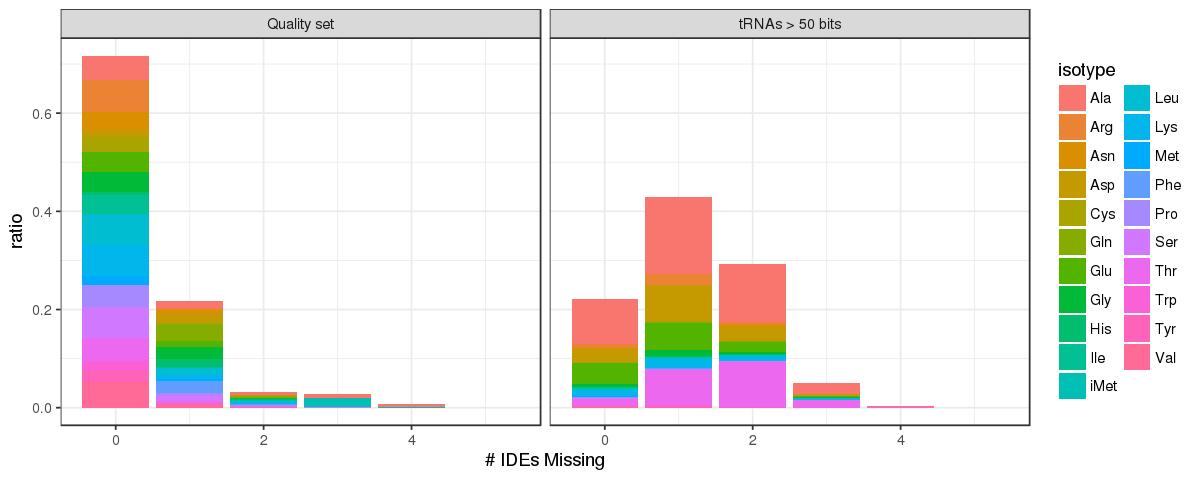

In [138]:
options(repr.plot.width=10, repr.plot.height=4)
missed %>% select(isotype, quality, Missed) %>%
  group_by(quality) %>%
  mutate(sum=length(quality)) %>%
  group_by(isotype, quality, Missed) %>%
  summarize(ratio=length(isotype)/sum[1]) %>%
  ggplot() + geom_bar(aes(x=Missed, y=ratio, fill=isotype), stat='identity') + facet_wrap(~ quality) + xlab("# IDEs Missing")

What are the most common IDEs that are missed?

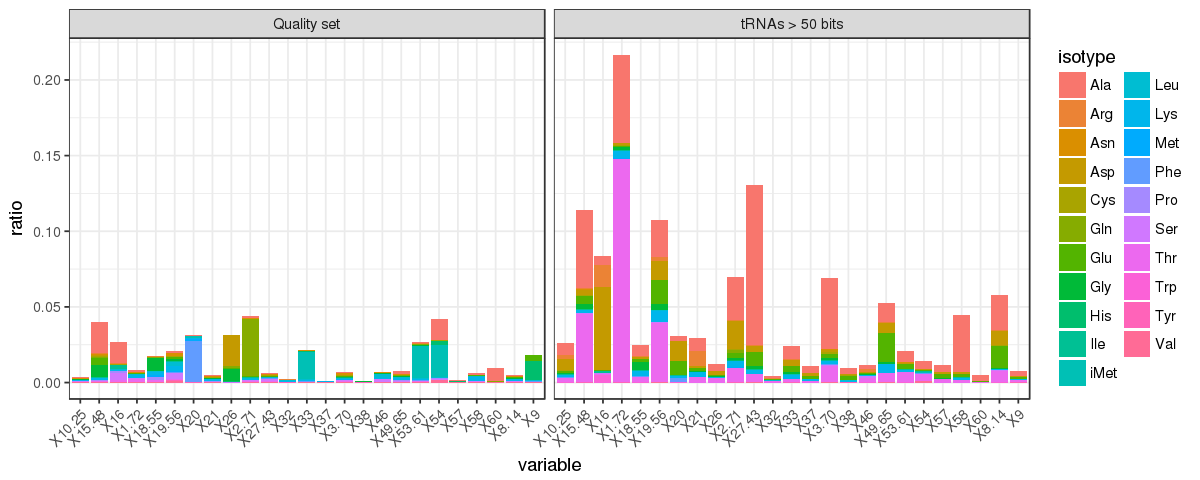

In [139]:
consensus_positions = c('X10.25', 'X15.48', 'X16', 'X1.72', 'X18.55', 'X19.56', 'X20', 'X21', 'X26', 'X2.71', 'X27.43', 'X32', 'X33', 'X37', 'X3.70', 'X38', 'X46', 'X49.65', 'X53.61', 'X54', 'X57', 'X58', 'X60', 'X8.14', 'X9')
missed_counts = missed %>% select(isotype, quality, one_of(consensus_positions)) %>% 
  melt(id.vars=c('isotype', 'quality')) %>% 
  group_by(variable, quality) %>%
  mutate(sum=length(value)) %>%
  group_by(isotype, variable, quality) %>%
  summarize(ratio=sum(!value)/sum[1],
            value=sum(!value))

options(repr.plot.width=10, repr.plot.height=4)
ggplot(missed_counts) + geom_bar(aes(x=variable, y=ratio, fill=isotype), stat='identity') + theme(axis.text.x=element_text(angle=45, hjust=1)) + facet_wrap(~ quality)

The y-axis here is the percentage of tRNAs for a IDE that don't contain the IDE. The left side is a script quality check - did I parse the tRNAs correctly? Since all of the IDE misses are under 5%, it is.

These two graphs indicate that the quality set - tRNAs that are more likely to be bona fide tRNAs - are more likely to contain the consensus elements. This is obvious because the quality set was used to determine the consensus elements.

Most (~70%) tRNAs contained all of the IDEs. However, if broken down to constituent isotypes, the ratios get worse. This may be a case of isotype-specific IDEs, in which an IDE is an antideterminant for the isotype, but there aren't enough tRNAs of that isotype to bring its frequency under 95%. A good example is with U54. As noted above, iMet has a strongly conserved A54. If we looked at the correlation between IDE misses, position, and isotype, we can quickly scan for isotype-specific IDEs that specifically differ from the consensus positions.

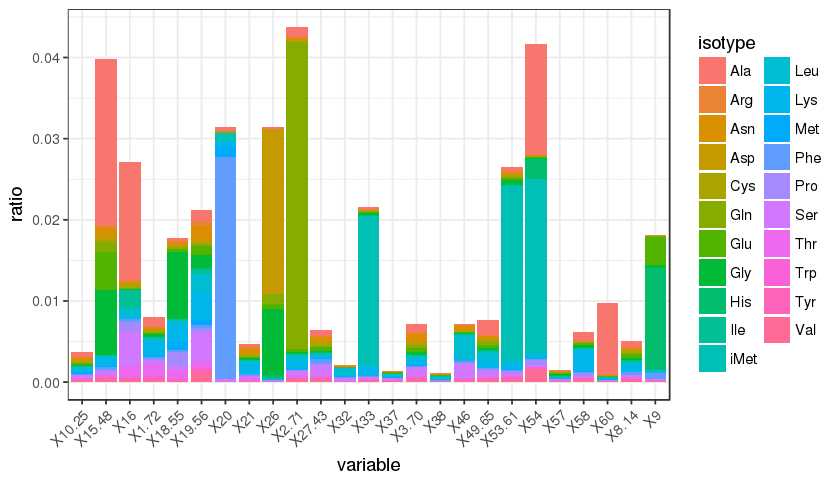

In [140]:
options(repr.plot.width=7, repr.plot.height=4)
missed_counts %>% filter(quality == "Quality set") %>% ggplot() + geom_bar(aes(x=variable, y=ratio, fill=isotype), stat='identity') + theme(axis.text.x=element_text(angle=45, hjust=1))

In [141]:
ratio_table = missed_counts %>% 
  filter(quality == "Quality set") %>% 
  select(isotype, variable, value) %>%
  spread(variable, value)
ratio_table = ratio_table[, -1]
rownames(ratio_table) = isotypes
ratio_table

Warning message:
: Setting row names on a tibble is deprecated.

,X10.25,X15.48,X16,X1.72,X18.55,X19.56,X20,X21,X26,X2.71,X27.43,X32,X33,X37,X3.70,X38,X46,X49.65,X53.61,X54,X57,X58,X60,X8.14,X9
Ala,32,1121,791,63,25,73,22,19,12,70,41,4,19,3,59,7,6,102,19,746,6,62,482,39,0
Arg,3,8,17,5,6,31,1,17,0,5,7,8,2,2,3,0,10,7,21,2,0,1,1,4,4
Asn,23,46,10,18,25,102,3,31,3,15,31,0,5,4,63,3,28,18,12,6,8,4,1,16,2
Asp,0,39,0,2,0,8,1,2,1106,4,3,0,2,0,3,0,1,1,3,3,0,2,3,4,1
Cys,12,17,29,10,10,16,10,22,3,7,25,3,4,1,11,5,7,19,14,4,3,6,2,17,0
Gln,4,62,3,9,12,13,1,2,68,2063,9,2,5,0,21,3,5,21,9,1,2,0,4,5,3
Glu,10,255,6,6,17,56,2,5,35,23,24,2,6,8,31,4,1,22,9,5,9,14,1,29,193
Gly,6,438,5,19,449,93,0,14,443,15,10,2,16,2,15,2,8,10,34,7,12,21,0,13,15
His,0,1,0,0,0,3,0,0,21,2,7,0,2,0,2,0,2,0,0,135,1,1,0,0,686
Ile,10,6,114,6,9,33,0,2,4,5,4,2,3,0,6,2,4,15,8,2,4,6,8,17,3


To find antideterminants, we can look at these counts, and pull out any of these that seem too high.

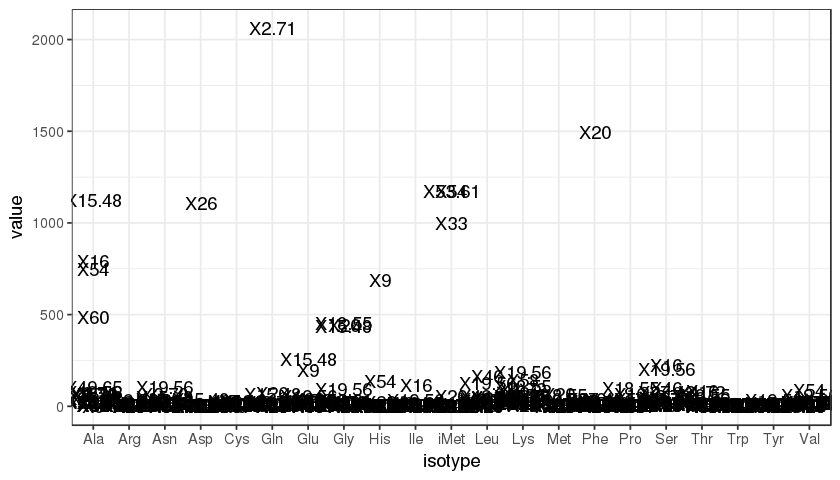

In [142]:
ggplot(missed_counts[missed_counts$quality == "Quality set", ]) + geom_text(aes(x=isotype, y=value, label=variable))

A good cutoff seems to be at 250 tRNAs. The following IDEs are therefore NOT consensus IDEs, since they also serve as antideterminants for Ala, Asp, Gln, Glu, Gly, His, iMet, and Phe.

In [143]:
missed_counts %>% filter(quality == "Quality set") %>% filter(value > 250) %>% arrange(variable)

,isotype,variable,quality,ratio,value
1,Ala,X15.48,Quality set,0.02053264,1121
2,Glu,X15.48,Quality set,0.004670672,255
3,Gly,X15.48,Quality set,0.008022566,438
4,Ala,X16,Quality set,0.01448824,791
5,Gly,X18.55,Quality set,0.008224046,449
6,Phe,X20,Quality set,0.02730969,1491
7,Asp,X26,Quality set,0.02025789,1106
8,Gly,X26,Quality set,0.008114148,443
9,Gln,X2.71,Quality set,0.03778665,2063
10,iMet,X33,Quality set,0.01827973,998


Interestingly, the average frequency actually rises, indicating that this is a tighter set of consensus IDEs. We'll add these exceptions to look at aberrant tRNAs.

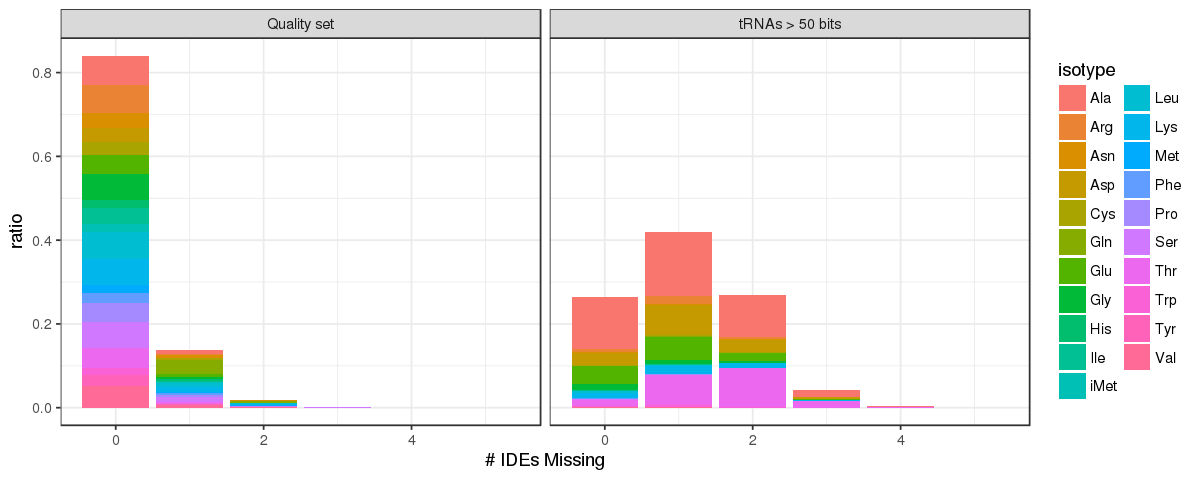

In [144]:
missed2 = identities %>% mutate(X10.25 = X10.25 %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"),
                                X15.48 = isotype %in% c("Ala", "Glu", "Gly") | X15.48 %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"),
                                X16 = isotype == "Ala" | X16 %in% c("G", "C", "U"),
                                X1.72 = X1.72 %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"),
                                X18.55 = isotype == "Gly" | X18.55 == "G:U",
                                X19.56 = X19.56 == "G:C",
                                X20 = isotype == "Phe" | X20 %in% c("A", "C", "U"),
                                X21 = X21 == "A",
                                X26 = isotype %in% c("Asp", "Gly") | X26 %in% c("A", "G", "U"),
                                X2.71 = X2.71 %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"),
                                X27.43 = X27.43 %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"),
                                X32 = X32 %in% c("C", "U"),
                                X33 = isotype == "iMet" | X33 == "U",
                                X37 = X37 %in% c('A', 'G'),
                                X3.70 = X3.70 %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"),
                                X38 = X38 %in% c("A", "C", "U"),
                                X46 = X46 %in% c('A', 'G'),
                                X49.65 = X49.65 %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"),
                                X53.61 = isotype == "iMet" | X53.61 %in% c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"),
                                X54 = isotype %in% c("Ala", "iMet") | X54 == "U",
                                X57 = X57 %in% c('A', 'G'),
                                X58 = X58 == "A",
                                X60 = isotype == "Ala" | X60 %in% c("A", "C", "U"),
                                X8.14 = X8.14 == "U:A",
                                X9 = isotype == "His" | X9 %in% c("A", "G")) %>%
  mutate(Missed=25 - (X10.25 + X15.48 + X16 + X1.72 + X18.55 + X19.56 + X20 + X21 + X26 + X2.71 + X27.43 + X32 + X33 + X37 + X3.70 + X38 + X46 + X49.65 + X53.61 + X54 + X57 + X58 + X60 + X8.14 + X9)) %>%
  mutate(quality=ifelse(quality, "Quality set", "tRNAs > 50 bits"))
options(repr.plot.width=10, repr.plot.height=4)
missed2 %>% select(isotype, quality, Missed) %>%
  group_by(quality) %>%
  mutate(sum=length(quality)) %>%
  group_by(isotype, quality, Missed) %>%
  summarize(ratio=length(isotype)/sum[1]) %>%
  ggplot() + geom_bar(aes(x=Missed, y=ratio, fill=isotype), stat='identity') + facet_wrap(~ quality) + xlab("# IDEs Missing")

In [145]:
table((missed2 %>% filter(quality == "Quality set"))$Missed)


    0     1     2     3     4 
45876  7532  1033   141    14 

Let's look at the tRNAs missing 4 IDEs first.

In [146]:
missed2 %>% filter(quality == "Quality set" & Missed == 4) %>%
  select(clade, species, species_long, isotype, anticodon, score, one_of(consensus_positions)) %>%
  arrange(species)

,clade,species,species_long,isotype,anticodon,score,X10.25,X15.48,X16,X1.72,X18.55,X19.56,X20,X21,X26,X2.71,X27.43,X32,X33,X37,X3.70,X38,X46,X49.65,X53.61,X54,X57,X58,X60,X8.14,X9
1,Vertebrata,calMil1,Callorhinchus milii (Elephant shark Dec. 2013 Callorhinchus_milii-6.1.3/calMil1),Phe,GAA,59.5,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE
2,Vertebrata,calMil1,Callorhinchus milii (Elephant shark Dec. 2013 Callorhinchus_milii-6.1.3/calMil1),Phe,GAA,55.3,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE
3,Vertebrata,danRer10,Danio rerio (Zebrafish Sep. 2014 GRCz10/danRer10),Gln,TTG,60.9,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE
4,Mammalia,eriEur2,Erinaceus europaeus (Hedgehog May 2012 EriEur2.0/eriEur2),Lys,CTT,59.6,TRUE,TRUE,TRUE,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE
5,Mammalia,eriEur2,Erinaceus europaeus (Hedgehog May 2012 EriEur2.0/eriEur2),Lys,CTT,57.1,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE
6,Vertebrata,gadMor1,Gadus morhua (Atlantic cod May 2010 Genofisk GadMor_May2010/gadMor1),Gln,CTG,60.1,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE
7,Vertebrata,gadMor1,Gadus morhua (Atlantic cod May 2010 Genofisk GadMor_May2010/gadMor1),Phe,GAA,55.5,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,FALSE,FALSE,TRUE
8,Vertebrata,gasAcu1,Gasterosteus aculeatus (stickleback) (Broad 1.0 Feb 2006),Ser,TGA,67.7,TRUE,TRUE,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
9,Mammalia,gorGor3,Gorilla gorilla gorilla (gorilla) (gorGor3.1 May 2011),Cys,GCA,62.5,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE
10,Mammalia,mm10,Mus musculus (mm10 Dec 2011),Leu,TAA,55.3,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE


This list of organism is enriched in organisms with huge numbers of repeats. We can take a look at the isotype frequencies by species to prove it.

In [147]:
nrow(identities)

[1] 110238

In [148]:
missed_tRNA_species = (missed2 %>% filter(quality == "Quality set" & Missed == 4))$species
identities %>% filter(species %in% missed_tRNA_species) %>%
  group_by(species, isotype) %>%
  summarize(isotype_count=n()) %>%
  spread(isotype, isotype_count)

,species,Ala,Arg,Asn,Asp,Cys,Gln,Glu,Gly,His,Ile,iMet,Leu,Lys,Met,Phe,Pro,Ser,Thr,Trp,Tyr,Val
1,calMil1,3117,55,43,257,54,21,54,196,21,46,16,65,59,24,43,27,64,9804,44,32,64
2,danRer10,308,568,815,144,93,275,374,775,185,283,135,902,1478,235,185,387,926,744,48,197,544
3,eriEur2,27,25,6,12,31,12,16,26,5,12,7,21,197,7,8,17,20,17,6,12,17
4,gadMor1,56,76,32,22,25,49,81,81,12,42,51,123,107,17,33,80,104,82,30,40,56
5,gasAcu1,135,207,123,137,97,134,77,74,40,160,110,88,160,146,35,105,171,145,75,17,45
6,gorGor3,27,28,20,9,25,17,12,21,7,19,8,24,22,8,6,17,25,19,6,14,20
7,mm10,32,24,14,14,55,15,19,27,10,15,7,27,31,7,8,16,22,18,8,10,22
8,ornAna1,59,38,21,20,34,24,30,58,6,31,20,52,64,10,26,29,41,46,12,22,43
9,oryLat2,9,72,8,12,18,53,25,26,19,33,8,40,16,7,10,15,39,76,8,9,16
10,xenTro3,128,194,45,55,80,62,124,256,31,100,47,150,171,72,54,135,198,264,31,104,135


A quick cursory glance at this table versus the 14 tRNAs above tells us the the following:
- calMil1 (elephant shark) has 43 Phe tRNAs, which is within what we'd expect to be a standard amount. If the missing-4-IDEs tRNAs were all Thr, this would be a different story.
    - However, this doesn't rule out the possibility that the two Phe tRNAs are inactive.
- Similar sentiments hold for Gln in danRer10 (zebrafish), Gln and Phe in gadMor1 (cod), Ser in gasAcu1 (stickleback), Cys in gorGor3 (gorilla), Leu in mouse, Phe and Ser in ornAna1 (platypus), Ser in oryLat2 (Medaka), and Leu in xenTro3 (frog).
    - Some of these are debatable - do organisms really need 100+ copies of tRNAs? That's what happened in some of these organisms. For example, frog has 12 isotypes boosted to 100+ copies. It's possible that many isotypes were subjected to amplification rather than just one or a few, as in elephant shark.
- Lysine in eriEur2 (hedgehog) seems to fit the bill of "repetitive element" more - 197 is an unusual amount of tRNAs, given that the average amount is about 15 among all other tRNAs in hedgehog.

# A more stringent view of consensus IDEs

As seen above, it's quite easy for a "consensus" IDE to have exceptions to the rule. The matrix above is also not well informed - the cutoff is biased towards high frequency tRNAs, as it's more likely to have more IDE misses when there are more tRNAs.

A better approach would be to **(a)** look at each isotype and make sure 90% of its tRNAs contain the IDE, **(b)** make sure each species has at least one tRNA of this isotype with that IDE, and **(c)** go down to the deepest level of clade specificity - in this case, we have 7 levels under eukaryote - and enforce the 90% rule for the isotype. (a)'s requirement is fulfilled by (c).

In [149]:
head(clade_iso_ac_freqs)

,clade,isotype,anticodon,positions,total,variable,value,freq
1,Fungi,Ala,AGC,X10.25,528,A,0,0
2,Fungi,Ala,AGC,X10.45,528,A,0,0
3,Fungi,Ala,AGC,X11.24,528,A,0,0
4,Fungi,Ala,AGC,X12.23,528,A,0,0
5,Fungi,Ala,AGC,X13.22,528,A,0,0
6,Fungi,Ala,AGC,X14,528,A,528,1


In [150]:
clade_iso_IDEs = clade_iso_ac_freqs %>%
  group_by(isotype, positions, clade, variable) %>% # remove duplicates
  summarize(count=sum(value), freq=sum(value)/sum(total)) %>%
  filter(freq > 0.9) %>%
  arrange(freq) %>%
  group_by(isotype, clade, positions) %>%
  filter(row_number(freq) == 1)

In [151]:
resolve_code = function(codes) {
  codes = unique(codes)
  x = c(A = all(codes %in% 'A'),
        C = all(codes %in% 'C'),
        G = all(codes %in% 'G'),
        U = all(codes %in% 'U'),
        Deletion = all(codes %in% 'Deletion'),
        Purine = all(codes %in% c('A', 'G', 'Purine')),
        Pyrimidine = all(codes %in% c('C', 'U', 'Pyrimidine')),
        Weak = all(codes %in% c('A', 'U', 'Weak')),
        Strong = all(codes %in% c('G', 'C', 'Strong')),
        Amino = all(codes %in% c('A', 'C', 'Amino')),
        Keto = all(codes %in% c('G', 'U', 'Keto')),
        B = all(codes %in% c('C', 'G', 'U', 'B', 'Strong', 'Pyrimidine', 'Keto')),
        D = all(codes %in% c('A', 'G', 'U', 'D', 'Purine', 'Weak', 'Keto')),
        H = all(codes %in% c('A', 'C', 'U', 'H', 'Amino', 'Weak', 'Pyrimidine')),
        V = all(codes %in% c('A', 'C', 'G', 'V', 'Amino', 'Purine', 'Strong')),
        GC = all(codes %in% 'GC'),
        AU = all(codes %in% 'AU'),
        UA = all(codes %in% 'UA'),
        CG = all(codes %in% 'CG'),
        GU = all(codes %in% 'GU'),
        UG = all(codes %in% 'UG'),
        PairDeletion = all(codes %in% 'PairDeletion'), 
        PurinePyrimidine = all(codes %in% c('AU', 'GC', 'PurinePyrimidine')),
        PyrimidinePurine = all(codes %in% c('UA', 'CG', 'PyrimidinePurine')),
        StrongPair = all(codes %in% c('GC', 'CG', 'StrongPair')),
        WeakPair = all(codes %in% c('AU', 'UA', 'WeakPair')),
        Wobble = all(codes %in% c('GU', 'UG', 'Wobble')),
        Paired = all(codes %in% c('AU', 'UA', 'CG', 'GC', 'GU', 'UG', 'Paired', 'PurinePyrimidine', 'PyrimidinePurine', 'StrongPair', 'WeakPair', 'Wobble')),
        Bulge = all(codes %in% 'Bulge'),
        Mismatched = all(codes %in% c('AA', 'GG', 'CC', 'UU', 'AG', 'AC', 'CA', 'CU', 'GA', 'UC', 'Mismatched', 'Paired', 'PurinePyrimidine', 'PyrimidinePurine', 'StrongPair', 'WeakPair', 'Wobble')))
  return(names(x[which(x)]))
}

In [152]:
consensus = clade_iso_IDEs %>% 
  group_by(positions) %>% 
  mutate(common = resolve_code(variable)[1]) %>%
  summarize(consensus = length(unique(common)) == 1 & n() == 147 & !is.na(common[1]), variable=common[1]) %>%
  filter(consensus) %>%
  select(positions, variable)
consensus

,positions,variable
1,X10.25,Paired
2,X14,A
3,X15,Purine
4,X1.72,Paired
5,X18,G
6,X18.55,Paired
7,X19,G
8,X19.56,GC
9,X21,A
10,X32,Pyrimidine


This takes care of requirement #1, which is making sure that 90% of tRNAs for each isotype have the IDE in question. Now, we check whether 50% of a species' tRNAs of each isotype contains the IDE.

In [153]:
check_IDE = function(position, code) {
  codes = list(A = "A", C = "C", G = "G", U = "U", Deletion = c("-", "."), Purine = c("A", "G"), Pyrimidine = c("C", "U"), Weak = c("A", "U"), Strong = c("G", "C"), Amino = c("A", "C"), Keto = c("G", "U"), B = c("C", "G", "U"), D = c("A", "G", "U"), H = c("A", "C", "U"), V = c("A", "C", "G"), D = c("A", "G", "U"), GC =  "G:C", AU =  "A:U", UA =  "U:A", CG =  "C:G", GU =  "G:U", UG =  "U:G", PairDeletion =  "-:-", PurinePyrimidine = c("A:U", "G:C"), PyrimidinePurine = c("U:A", "C:G"), StrongPair = c("G:C", "C:G"), WeakPair = c("A:U", "U:A"), Wobble = c("G:U", "U:G"), Paired = c("A:U", "U:A", "C:G", "G:C", "G:U", "U:G"), Bulge = c("A:-", "U:-", "C:-", "G:-", "-:A", "-:G", "-:C", "-:U"), Mismatched = c("A:A", "G:G", "C:C", "U:U", "A:G", "A:C", "C:A", "C:U", "G:A", "U:C")) 
  codes_str = paste0("c('", paste0(codes[[code]], collapse="', '"), "')")
  df = identities %>% select_('species', 'isotype', position) %>%
    group_by_('species', 'isotype') %>% 
    summarize_(match = paste0("sum(", position, " %in% ", codes_str, ")"),
               miss = paste0("sum(!(", position, " %in% ", codes_str, "))")) %>%
    mutate(ubiquitous = match > miss)
  return(all(df$ubiquitous))
}

In [162]:
consensus[apply(consensus, 1, function(row) check_IDE(row['positions'], row['variable'])), ]

,positions,variable
1,X14,A
2,X19,G
3,X19.56,GC
4,X33,Pyrimidine
5,X38,H
6,X54,H
7,X55,Pyrimidine
8,X56,C
9,X57,Purine
10,X8,U


double check, A21

In [171]:
position = 'X21'
codes_str = "c('A')"
df = identities %>% filter(quality) %>% 
    select_('species', 'isotype', position) %>%
    group_by_('species', 'isotype') %>% 
    summarize_(match = paste0("sum(", position, " %in% ", codes_str, ")"),
               miss = paste0("sum(!(", position, " %in% ", codes_str, "))")) %>%
    mutate(ubiquitous = match > miss)
df[!df$ubiquitous, ]

,species,isotype,match,miss,ubiquitous
1,aspeNidu_FGSC_A4,Phe,0,5,FALSE
2,fusaGram_CS3005,Cys,2,3,FALSE
3,fusaGram_PH_1_NRRL_31084,Cys,2,3,FALSE
4,fusaPseu_CS3096,Cys,2,3,FALSE
5,fusaPseu_CS3270,Cys,2,3,FALSE
6,fusaVert_7600,Cys,2,3,FALSE
7,sporReil_SRZ2,Phe,0,4,FALSE
8,ustiMayd_521,Phe,0,3,FALSE


In [172]:
identities %>% filter(quality & species == "fusaGram_CS3005" & isotype == "Cys")

,clade,domain,isotype,seqname,species,species_long,isotype_ac,anticodon,score,isoscore,GC,D.loop,AC.loop,TPC.loop,V.arm,intron,insertions,deletions,quality,restrict,X0i1,X0i2,X0i3,X0i4,X0i5,X0i6,X0i7,X0i8,X0i9,X0i10,X0i11,X1.72,X1,X1i1,X2.71,X2,X2i1,X3.70,X3,X3i1,X3i2,X3i3,X3i4,X3i5,X3i6,X3i7,X4.69,X4,X4i1,X4i2,X4i3,X4i4,X4i5,X4i6,X4i7,X4i8,X4i9,X4i10,X4i11,X5.68,X5,X5i1,X5i2,X5i3,X5i4,X5i5,X5i6,X5i7,X6.67,X6,X6i1,X7.66,X7,X7i1,X7i2,X7i3,X7i4,X7i5,X7i6,X7i7,X7i8,X7i9,X7i10,X7i11,X7i12,X7i13,X7i14,X8,X8.14.21,X8.14,X8i1,X8i2,X8i3,X8i4,X9,X9.12.23,X9.23,X9i1,X9i2,X9i3,X10.25,X10,X10.25.45,X10.45,X10i1,X11.24,X11,X12.23,X12,X12i1,X12i2,X12i3,X12i4,X13.22,X13,X13.22.46,X13i1,X14,X14i1,X14i2,X14i3,X14i4,X14i5,X14i6,X14i7,X14i8,X14i9,X14i10,X14i11,X14i12,X14i13,X14i14,X14i15,X14i16,X14i17,X14i18,X14i19,X14i20,X14i21,X14i22,X14i23,X14i24,X14i25,X15,X15.48,X16,X16i1,X16i2,X16i3,X16i4,X16i5,X16i6,X16i7,X16i8,X16i9,X16i10,X16i11,X16i12,X16i13,X16i14,X16i15,X16i16,X16i17,X16i18,X16i19,X16i20,X17,X17i1,X17i2,X17i3,X18,X18.55,X19,X19.56,X20,X20i1,X20i2,X20i3,X20i4,X20i5,X20i6,X20i7,X20i8,X20i9,X20i10,X20a,X20b,X21,X21i1,X22,X22.46,X22i1,X23,X23i1,X24,X24i1,X25,X25i1,X25i2,X25i3,X25i4,X25i5,X25i6,X25i7,X25i8,X25i9,X25i10,X25i11,X25i12,X25i13,X26,X26.44,X26i1,X26i2,X26i3,X26i4,X27.43,X27,X27i1,X27i2,X27i3,X27i4,X27i5,X28.42,X28,X28i1,X28i2,X28i3,X28i4,X29.41,X29,X29i1,X30.40,X30,X30i1,X31.39,X31,X32,X33,X34,X35,X35i1,X36,X37,X37i1,X37i2,X37i3,X37i4,X37i5,X37i6,X37i7,X37i8,X37i9,X37i10,X37i11,X37i12,X37i13,X37i14,X37i15,X37i16,X37i17,X37i18,X37i19,X37i20,X37i21,X37i22,X37i23,X37i24,X37i25,X37i26,X37i27,X37i28,X37i29,X37i30,X37i31,X37i32,X37i33,X37i34,X37i35,X37i36,X37i37,X37i38,X37i39,X37i40,X37i41,X37i42,X37i43,X37i44,X37i45,X37i46,X37i47,X37i48,X37i49,X37i50,X37i51,X37i52,X37i53,X37i54,X37i55,X37i56,X37i57,X37i58,X37i59,X37i60,X37i61,X37i62,X37i63,X37i64,X37i65,X37i66,X37i67,X37i68,X37i69,X37i70,X37i71,X37i72,X37i73,X37i74,X37i75,X37i76,X37i77,X37i78,X37i79,X37i80,X37i81,X37i82,X37i83,X37i84,X37i85,X37i86,X37i87,X37i88,X37i89,X37i90,X37i91,X37i92,X37i93,X37i94,X37i95,X37i96,X37i97,X37i98,X37i99,X37i100,X37i101,X37i102,X37i103,X37i104,X37i105,X37i106,X37i107,X37i108,X37i109,X37i110,X37i111,X37i112,X37i113,X37i114,X37i115,X37i116,X37i117,X37i118,X37i119,X37i120,X37i121,X37i122,X37i123,X37i124,X37i125,X37i126,X37i127,X37i128,X37i129,X37i130,X37i131,X37i132,X37i133,X37i134,X37i135,X37i136,X37i137,X37i138,X37i139,X37i140,X37i141,X37i142,X37i143,X37i144,X37i145,X37i146,X37i147,X37i148,X37i149,X37i150,X37i151,X37i152,X37i153,X37i154,X37i155,X37i156,X37i157,X37i158,X37i159,X37i160,X37i161,X37i162,X37i163,X37i164,X37i165,X37i166,X37i167,X37i168,X37i169,X37i170,X37i171,X37i172,X37i173,X37i174,X37i175,X37i176,X37i177,X37i178,X37i179,X37i180,X37i181,X37i182,X37i183,X37i184,X37i185,X37i186,X37i187,X37i188,X37i189,X37i190,X37i191,X37i192,X37i193,X37i194,X37i195,X37i196,X37i197,X37i198,X37i199,X37i200,X37i201,X37i202,X37i203,X37i204,X37i205,X37i206,X37i207,X37i208,X37i209,X37i210,X37i211,X37i212,X37i213,X37i214,X37i215,X37i216,X37i217,X37i218,X37i219,X37i220,X37i221,X37i222,X37i223,X37i224,X37i225,X37i226,X37i227,X37i228,X37i229,X37i230,X37i231,X37i232,X37i233,X37i234,X37i235,X37i236,X37i237,X37i238,X37i239,X37i240,X37i241,X37i242,X37i243,X37i244,X37i245,X37i246,X37i247,X37i248,X37i249,X37i250,X37i251,X37i252,X37i253,X37i254,X37i255,X37i256,X37i257,X37i258,X37i259,X37i260,X37i261,X37i262,X37i263,X37i264,X37i265,X37i266,X37i267,X37i268,X37i269,X37i270,X37i271,X37i272,X37i273,X37i274,X37i275,X37i276,X37i277,X37i278,X37i279,X37i280,X37i281,X37i282,X37i283,X37i284,X37i285,X37i286,X37i287,X37i288,X37i289,X37i290,X37i291,X37i292,X37i293,X37i294,X37i295,X37i296,X37i297,X37i298,X37i299,X37i300,X37i301,X37i302,X37i303,X37i304,X37i305,X37i306,X37i307,X37i308,X37i309,X37i310,X37i311,X37i312,X37i313,X37i314,X37i315,X37i316,X37i317,X37i318,X37i319,X37i320,X37i321,X37i322,X37i323,X37i324,X37i325,X37i326,X37i327,X37i328,X37i329,X37i330,X37i331,X37i332,X37i333,X37i334,X3